### **Aluna**: Lais de Souza Ziegler
# 🛳️ Predição de sobrevivência em Naufrágio
Dataset: treino.csv

O projeto de predição de sobrevivência em naufrágios utiliza um conjunto de dados inspirado em um incidente recente no Mediterrâneo, contendo informações sobre 7.124 passageiros a bordo de um navio. As variáveis incluem identificação única do passageiro, nome, informações da cabine (deck, número e posição), procedência, destino, idade, status de VIP, modalidade de hospedagem e gastos com serviços a bordo. O objetivo é prever a probabilidade de um passageiro sobreviver ao naufrágio com base em suas características.

### 1️⃣ Leitura e exploração dos dados
---
#### Importando as bibliotecas necessárias para a análise de dados

In [45]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc 

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder

#### Carregando o conjunto de dados a partir de um arquivo CSV 
- Em seguida, imprimindo os tipos de dados de cada coluna para entender a estrutura do DataFrame
- Exibindo as primeiras cinco linhas do conjunto de dados para uma visão geral dos dados

In [46]:
df = pd.read_csv("treino.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IDpassageiro   1000 non-null   object
 1   Nome           1000 non-null   object
 2   Deck           1000 non-null   object
 3   NumeroCabine   1000 non-null   int64 
 4   PosicaoCabine  1000 non-null   object
 5   Procedencia    1000 non-null   object
 6   Destino        1000 non-null   object
 7   Idade          1000 non-null   int64 
 8   VIP            1000 non-null   bool  
 9   AllInclusive   1000 non-null   bool  
 10  ServicoCabine  1000 non-null   int64 
 11  Restaurante    1000 non-null   int64 
 12  Shopping       1000 non-null   int64 
 13  SPA            1000 non-null   int64 
 14  ParquedeAguas  1000 non-null   int64 
 15  Sobrevivente   1000 non-null   bool  
dtypes: bool(3), int64(7), object(6)
memory usage: 104.6+ KB


,IDpassageiro,Nome,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente
0,5647_02,Chabih Matoltuble,D,193,P,Finland,Peru,61,False,True,239,1288,3380,1158,587,True
1,0107_01,Coobix Hart,A,1202,S,Argentina,Argentina,31,True,False,466,6,11299,1598,506,True
2,4158_01,Doryn Noeley,G,107,P,Peru,China,49,True,True,1240,674,10989,806,463,True
3,1316_01,Sadrus Quelfly,G,545,S,Indonesia,Greenland,32,False,True,176,1186,8750,1438,379,True
4,9069_05,Mirfark Taketiatim,D,392,P,Indonesia,Brazil,5,False,False,90,1318,161,2853,203,True


#### Exibindo a forma do DataFrame, que retorna o número de linhas e colunas, 

In [47]:
print(df.shape)

(1000, 16)


#### Exibindo um resumo estatístico das colunas numéricas do DataFrame

In [48]:
df.describe()

,NumeroCabine,Idade,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,688.466000,39.816000,883.92700,690.624000,7410.141000,1518.977000,356.879000
std,404.869011,23.346203,498.44474,419.069741,4413.046425,861.974722,202.812532
min,1.000000,0.000000,4.00000,3.000000,2.000000,0.000000,0.000000
25%,332.750000,19.000000,473.50000,312.750000,3666.750000,797.750000,184.000000
50%,675.000000,40.000000,878.00000,680.000000,7309.000000,1472.500000,365.500000
75%,1049.500000,61.000000,1297.50000,1045.500000,11279.750000,2297.500000,532.000000
max,1365.000000,79.000000,1741.00000,1425.000000,15234.000000,2955.000000,705.000000


### Verificando se há valores ausentes

In [49]:
df.isnull().sum()

IDpassageiro     0
Nome             0
Deck             0
NumeroCabine     0
PosicaoCabine    0
Procedencia      0
Destino          0
Idade            0
VIP              0
AllInclusive     0
ServicoCabine    0
Restaurante      0
Shopping         0
SPA              0
ParquedeAguas    0
Sobrevivente     0
dtype: int64

1. Visão Geral das Colunas e Tipos de Dados:
2. Valores Ausentes:
3. Duplicatas:
4. Resumo Estatístico das Variáveis Numéricas:
5. Distribuição das Variáveis Categoricas
6. Distribuição de Idades
7. Gráficos de Barras para Variáveis Categóricas:
8. Gráfico de Sobrevivência: 

## Análise de Passageiros em Família e Solo
Identificar se os passageiros se estão viajando sozinhos ou em grupo (família) com base em um identificador fornecido.

- Separar o ID de Grupo e o Número do Integrante
    - Dividimos o identificador único de cada passageiro (`IDpassageiro`) em duas partes: o grupo ao qual o passageiro pertence e o número de cada integrante dentro desse grupo. Isso nos permite rastrear quantos passageiros fazem parte de cada grupo.

- Identificar se o Passageiro está em Família
    - Com a contagem de passageiros por grupo, marcamos os passageiros que pertencem a grupos com mais de um integrante como "Em Grupo", e os demais como "Solo".


In [ ]:
df[['Grupo', 'Integrante']] = df['IDpassageiro'].str.split('_', expand=True)

group_counts = df['Grupo'].value_counts()

df['EmGrupo'] = df['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

print(df.EmGrupo.value_counts())

### Visualizar a Distribuição de Passageiros em Família e Solo
Gráfico de barras para mostrar visualmente a quantidade de passageiros que viajam sozinhos em comparação aos que viajam em grupo, facilitando a análise da distribuição entre esses dois tipos de passageiros.

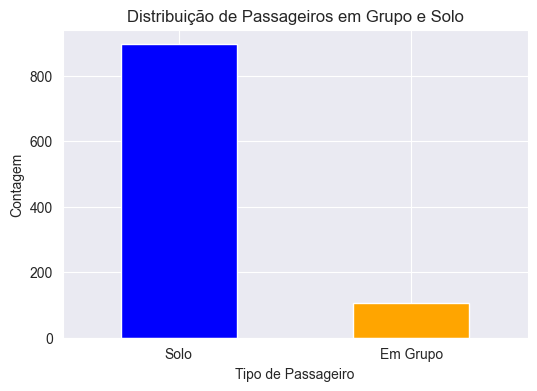

In [39]:
plt.figure(figsize=(6, 4))
df['EmGrupo'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Solo', 'Em Grupo'], rotation=0)
plt.title('Distribuição de Passageiros em Grupo e Solo')
plt.xlabel('Tipo de Passageiro')
plt.ylabel('Contagem')
plt.show()

### Visualizar a Distribuição de Passageiros em Família e Solo
Mostrando visualmente a quantidade de passageiros em cada Deck do navio.

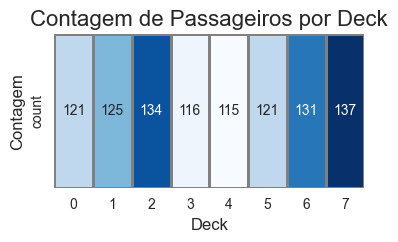

In [43]:
deck_counts = df['Deck'].value_counts().reset_index()
deck_counts_sorted = deck_counts.sort_values(by='Deck', ascending=True)
deck_counts.columns = ['Deck', 'Contagem']

plt.figure(figsize=(4, 2))
sns.heatmap(deck_counts_sorted.set_index('Deck').T, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='gray')

plt.title('Contagem de Passageiros por Deck', fontsize=16)
plt.xlabel('Deck', fontsize=12)
plt.show()

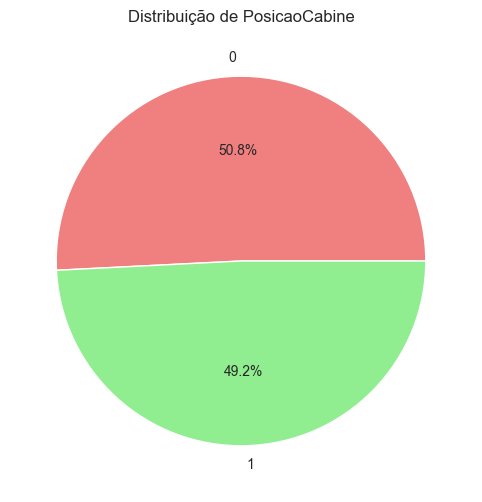

In [44]:
# Gráfico 2: Distribuição de 'PosicaoCabine' (P vs S)
plt.figure(figsize=(8, 6))
df['PosicaoCabine'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Distribuição de PosicaoCabine')
plt.ylabel('')  # Remove o rótulo 'y'
plt.show()

## Preparação de Dados

- **Codificação de variáveis**
   - `Deck` foi transformado em códigos numéricos.
   - `PosicaoCabine` foi mapeada para 1 (P) e 0 (S).
   - Colunas booleanas (`VIP`, `AllInclusive`, `Sobrevivente`) foram convertidas para 0 e 1.

- **Criação de novas colunas**
   - `TotalGasto` foi calculado somando os gastos em diferentes categorias.
   - `GrupoHetario` e `RangeGasto` foram criados para agrupar idade e gastos em faixas.

- **Conversão para códigos numéricos**: 
   - `GrupoHetario` e `RangeGasto` foram convertidos para valores numéricos.

- **Origem e destino**:
   - `MesmaOrigemDestino` foi criada para indicar se a procedência e destino são iguais.

- **Remoção de colunas**: 
   - Colunas de gastos individuais foram removidas.


In [41]:
df['Deck'] = df['Deck'].astype('category').cat.codes
df['PosicaoCabine'] = df['PosicaoCabine'].map({'P': 1, 'S': 0})

df['VIP'] = df['VIP'].astype(int)
df['AllInclusive'] = df['AllInclusive'].astype(int)
df['Sobrevivente'] = df['Sobrevivente'].astype(int)

df['TotalGasto'] = df[['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas']].sum(axis=1)

df['GrupoHetario'] = pd.cut(df['Idade'], bins=[-1, 18, 30, 50, 100], labels=["0-18", "19-30", "31-50", "51+"])
df['RangeGasto'] = pd.cut(df['TotalGasto'], bins=[-1, 500, 1000, 2000, 5000, 10000, 30000], labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5001-10000', '10000+'], right=False)

df['GrupoHetarioCode'] = df['GrupoHetario'].cat.codes
df['RangeGastoCode'] = df['RangeGasto'].cat.codes

df['MesmaOrigemDestino'] = (df['Procedencia'] == df['Destino']).astype(int)

df.drop(['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas'], axis=1, inplace=True)

In [42]:
# Contagem de passageiros por Deck
deck_counts = df['Deck'].value_counts().reset_index()
deck_counts.columns = ['Deck', 'Contagem']

# Estilizando a tabela no Jupyter Notebook
deck_counts.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'gray')]}]
)


,Deck,Contagem
0,7,137
1,2,134
2,6,131
3,1,125
4,5,121
5,0,121
6,3,116
7,4,115
